Generating statistics: https://hoxhunt.com/


<IPython.core.display.Javascript object>


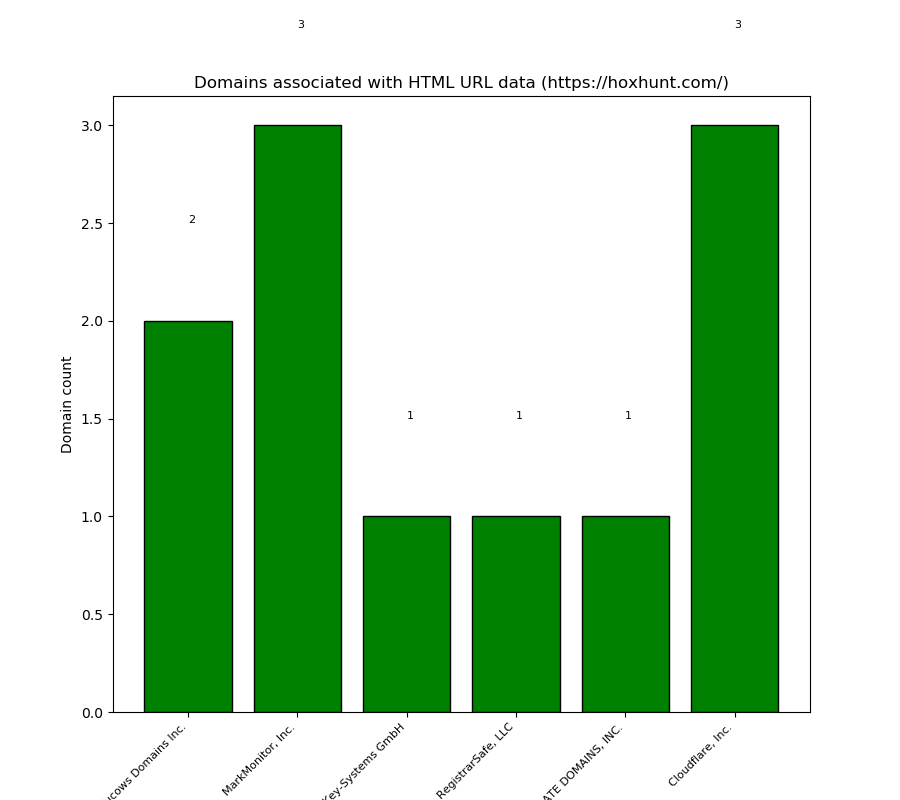

Generating statistics: https://hs.fi


<IPython.core.display.Javascript object>


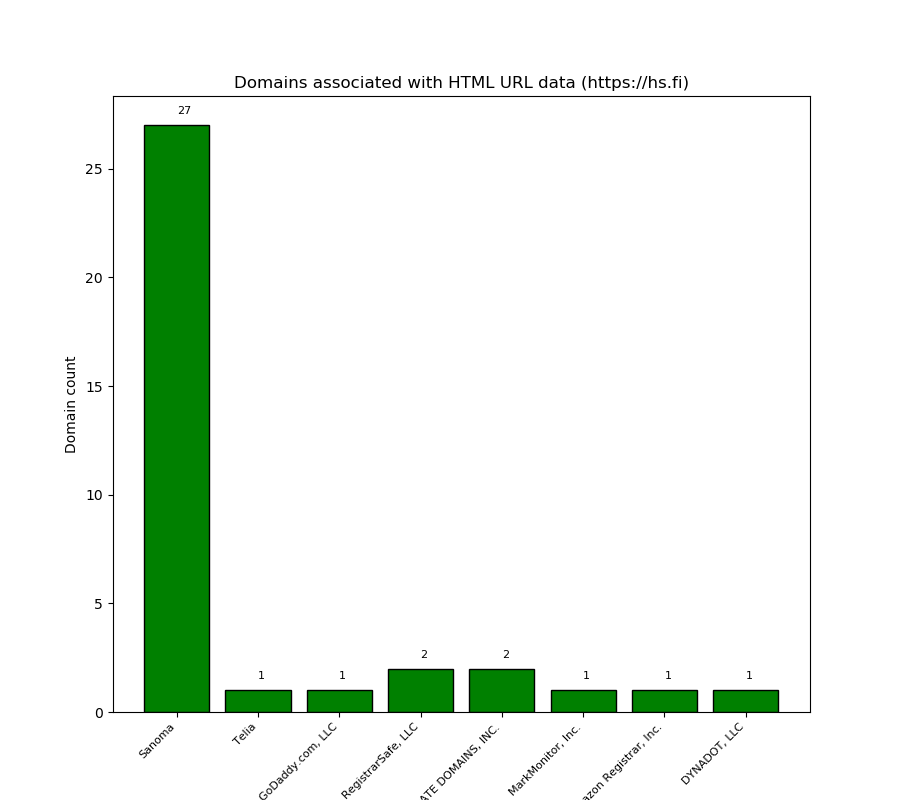

Generating statistics: https://ts.fi


<IPython.core.display.Javascript object>


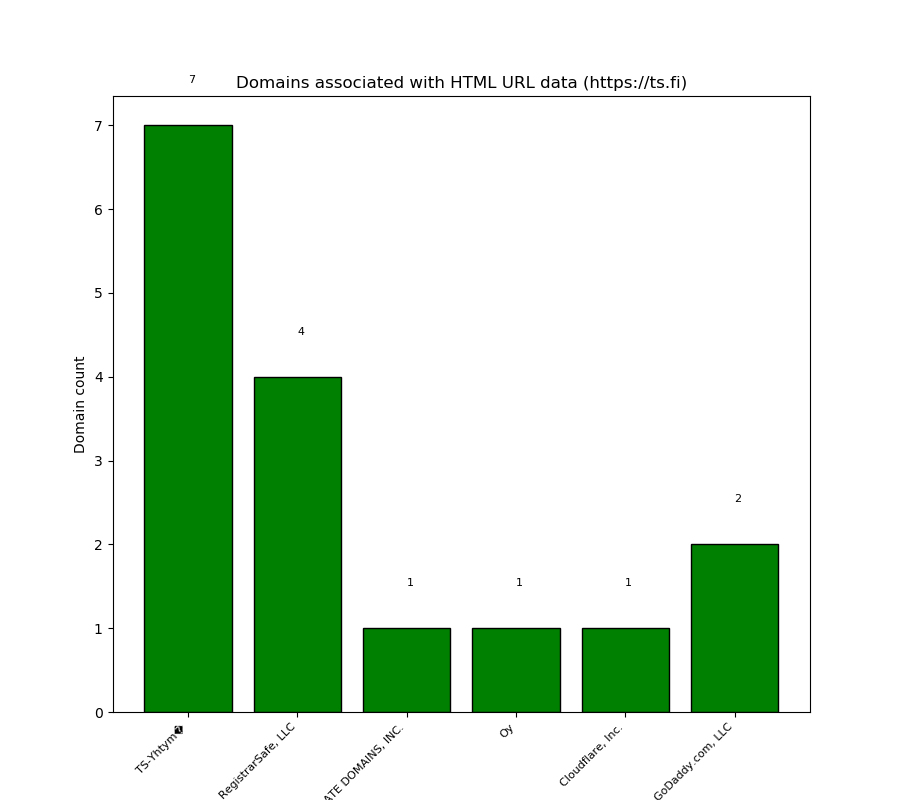

Generating statistics: https://facebook.com


<IPython.core.display.Javascript object>


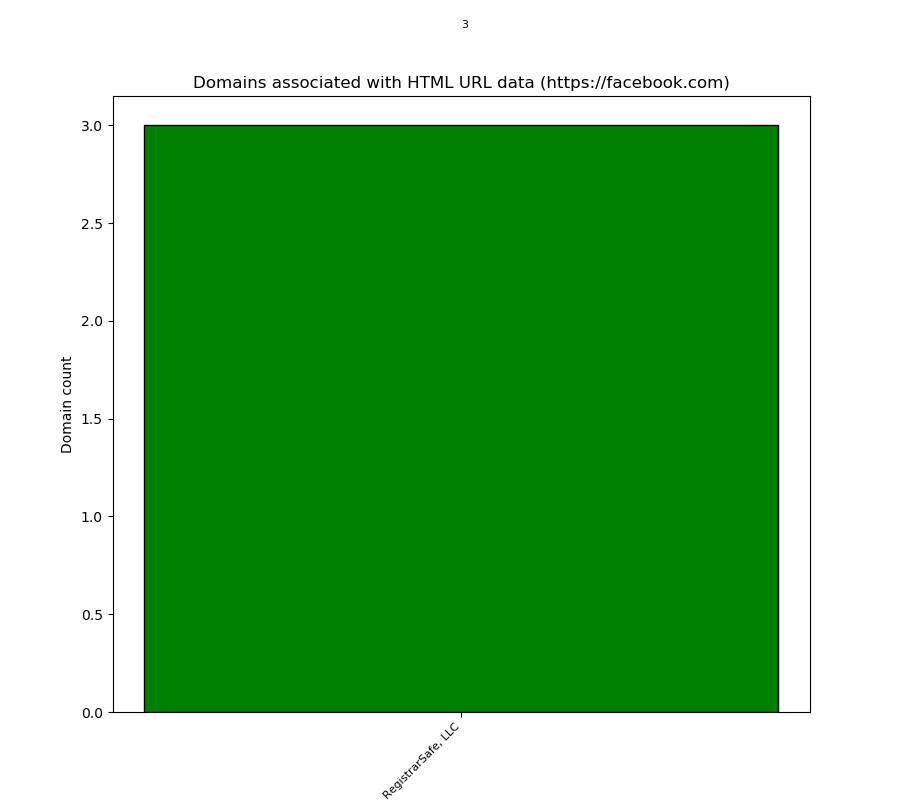

In [3]:
#!/bin/env python

"""
URL data extractor

Pekka Helenius <pekka [dot] helenius [at] fjordtek [dot] com>

Requirements:

Python 3
Python 3 BeautifulSoup4 (python-beautifulsoup4)
Python 3 whois (python-whois; PyPI)
Python 3 JSON Schema (python-jsonschema)
Python 3 Numpy (python-numpy)
Python 3 matplotlib (python-matplotlib)

TODO: URL domain part length comparison analysis
TODO: URL non-TLD part length comparison analysis
 - in phishing webpages, URL tends to be much longer than legitimate webpages
   however, domains themselves tend to be much shorter (without TLD)
 - phishing URLs often contain more number of dots and subdomains than legitimate URLs
 - legitimate: robots.txt redirects bots to a legitimate domain rather than to the original phishing domain

TODO: Website visual similarity analysis
TODO: consistency of RDN usage in HTML data
"""

######################################

%matplotlib notebook
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup as bs
from collections import Counter
from datetime import date, datetime
import json
import os
import re
import requests
from time import sleep
import urllib
from whois import whois

# Target URLs
urls = [
  "https://hoxhunt.com/",
  "https://hs.fi",
  "https://ts.fi",
  "https://facebook.com"
]

# Some web servers may block our request unless we set a widely used, well-known user agent string
request_headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.190 Safari/537.36'
}

# Date format for domain timestamps
dateformat = "%Y/%m/%d"

# All webpages may not like fetching data too fast
# Sleep time in seconds
sleep_interval_between_requests = 0.5

# Write JSON results to a file?
use_file = True
# Full file path + name
filename = os.getcwd() + "/" + "url_info.json"

# Generate plot from existing JSON data?
plot_only = False

# Save generated plot images?
save_plot_images = True

# DPI of plot images
plot_images_dpi = 150

# Common link attribute references in various HTML elements
link_refs = {
  'a':      'href',
  'img':    'src',
  'script': 'src'
}

############################################################################
############################################################################

class json_url_data(object):

#  def __init__(self):

######################################
  """
  Set a new HTTP session and get response.

  Returns a requests.models.Response object.
  """
  def set_session(self, url, method='get', redirects=True):
  
    # HTTP response status codes 1XX, 2XX and 3XX are OK
    # Treat other codes as errors
    sc = re.compile(r"^[123]{1}[0-9]{2}")
  
    sleep(sleep_interval_between_requests)
  
    try:
      session  = requests.Session()
      response = session.request(method, url, headers=request_headers, allow_redirects=redirects)
  
      if not sc.match(str(response.status_code)):
        raise Exception("Error: got invalid response status from the web server")
      return response
  
    except:
      raise Exception("Error: HTTP session could not be established. URL: '" + url + "' (method: " + method + ")") from None

######################################
  """
  Fetch HTML data.

  Returns a bs4.BeautifulSoup object.
  """
  def get_html_data(self, url):
  
    try:
      data = bs(self.set_session(url).content, 'html.parser')
      return data
    except:
      raise Exception("Error: HTML data could not be retrieved")

######################################
  """
  Get URL redirects and related HTTP status codes.

  Returns a list object.
  """
  def get_url_redirects(self, url):
  
    response = self.set_session(url)
    list_data = []
  
    if response.history:
      
      for r in response.history:
        list_data.append({'redirect_url': r.url, 'status': r.status_code})
  
    return list_data

######################################
  """
  Extract title HTML element contents from given HTML data.

  Returns a string object.
  """
  def get_webpage_title(self, url):
  
    html_data = self.get_html_data(url)
  
    title = html_data.title.string
    return title

######################################
  """
  Get WHOIS domain data.

  Returns a dict object.
  """
  def get_whois_data(self, url):
    dict_data = whois(url)
    return dict_data

######################################
  """
  Get domain name based on WHOIS domain data.
  """
  def get_domain_name(self, url):
    domain_name = self.get_whois_data(url).domain_name
  
    if type(domain_name) is list:
      return domain_name[0].lower()
    else:
      return domain_name.lower()

######################################
  """
  Get initial and final URLs
  
  Compare whether the final (destination) URL
  matches with the initial URL in a request.
  
  Returns a dict object.
  """
  def get_startfinal_urls(self, url):
  
    response    = self.set_session(url)
    end_url     = response.url
  
    start_match = False
    final_match = False
  
  #  dr = re.compile(r"^([a-z]+://)?([^/]+)")
  #  dr_group_lastindex = dr.match(url).lastindex
  #  domain_name = dr.match(url).group(dr_group_lastindex)
  
    domain_name = self.get_domain_name(url)
  
    if re.search(domain_name, end_url):
      final_match = True
  
    dict_data = {
      'startfinal_urls': {
        'start_url': {
          'url': url
        },
        'final_url': {
          'url': end_url, 'domain_match': final_match
        }
      }
    }
  
    return dict_data

######################################
  """
  Get domain registrar
  
  Returns a dict object.
  """
  def get_domain_registrar(self, url):
    dict_data = {'domain_registrar': self.get_whois_data(url).registrar }
    return dict_data

######################################
  """
  Do comparison between the domain name, extracted
  from WHOIS domain data and contents of a title HTML
  element, extracted from HTML data based on a given URL.
  
  Returns a dict object.
  """
  def get_domain_title_match(self, url):
  
    domain_name = self.get_domain_name(url)
    title = self.get_webpage_title(url)
  
    # If is string:
    if type(domain_name) is str:
      if re.search(domain_name, title, re.IGNORECASE):
        match = True
      else:
        match = False
  
    # If is list:
    elif type(domain_name) is list:
      for d in domain_name:
        if re.search(d, title, re.IGNORECASE):
          match = True
          break
        else:
          match = False
    else:
      match = False
  
    dict_data = {
      'webpage_title': title,
      'domain_in_webpage_title': match
    }
  
    return dict_data

######################################
  """
  Get a single timestamp from given data
  
  Two scenarios are considered: dates argument is either
  a list or a string. If it is a list, then we need
  to decide which date value to extract.
  
  Returns a date object.
  """
  def get_single_date(self, dates, newest=False):
  
    dates_epoch = []
  
    if type(dates) is list:
      for d in dates:
        dates_epoch.append(d.timestamp())
    else:
      dates_epoch.append(dates.timestamp())
  
    return datetime.fromtimestamp(sorted(dates_epoch, reverse=newest)[0])

######################################
  """
  Get domain time information based on WHOIS domain data.
  
  Returns a dict object.
  """
  def get_domain_timeinfo(self, url):
  
    whois_data = self.get_whois_data(url)
    domain_creation_date   = self.get_single_date(whois_data.creation_date, newest = False)
    domain_updated_date    = self.get_single_date(whois_data.updated_date, newest = False)
    domain_expiration_date = self.get_single_date(whois_data.expiration_date, newest = False)
  
    dict_data = {
      'domain_timestamps':
        {
          'created': domain_creation_date.strftime(dateformat),
          'updated': domain_updated_date.strftime(dateformat),
          'expires': domain_expiration_date.strftime(dateformat)
        }
      }
  
    return dict_data

######################################
  """
  Get domain time information based on WHOIS domain data,
  relative to the current date (UTC time).
  
  Returns a dict object.
  """
  def get_domain_timeinfo_relative(self, url):
  
    date_now = datetime.utcnow()
  
    whois_data = self.get_whois_data(url)
    domain_creation_date   = self.get_single_date(whois_data.creation_date, newest = False)
    domain_updated_date    = self.get_single_date(whois_data.updated_date, newest = False)
    domain_expiration_date = self.get_single_date(whois_data.expiration_date, newest = False)
  
    dict_data = {
      'domain_timestamps_relative':
        {
          'current_date':      (date_now.strftime(dateformat)),
          'created_days_ago':  (date_now - domain_creation_date).days,
          'updated_days_ago':  (date_now - domain_updated_date).days,
          'expires_days_left': (domain_expiration_date - date_now).days
        }
      }
  
    return dict_data

######################################
  """
  Determine whether URL matches syntaxes such as
  '../foo/bar/'
  '/foo/../../bar/,
  'https://foo.bar/foo/../'
  
  etc.
  
  Returns a boolean object.
  """
  def is_multidot_url(self, url):
  
    multidot = re.compile(r".*[.]{2}/.*")
  
    if multidot.match(url):
      return True
    return False

######################################
  """
  Get HTML element data from HTML data contents.
  
  Two fetching methods are supported:
  - A) use only HTML element/tag name and extract raw contents of
       these tags
  - B) use both HTML element/tag name and more fine-grained
       inner attribute name to determine which HTML elements are extracted
  
      Special case - URL link references:
       - attributes 'href' or 'src' are considered as link referrals and 
         they are handled in a special way
         - A) link referrals to directly to domain are placed in 'self_refs' list
              (patterns: '/', '#', '../' and '/<anything>')
         - B) link referrals to external domains are placed in 'ext_refs' list
              (patterns such as 'https://foo.bar.dot/fancysite' etc.)
  
         - Both A) and B) link categories have 'normal' and 'multidot' subcategories
           - normal links do not contain pattern '../'
           - multidot links contain '../' pattern
  
  Returns a dict object.
  """
  
  def get_tag_data(self, url, tag, attribute=None):
  
    html_data   = self.get_html_data(url)
    domain_name = self.get_domain_name(url)
    data        = []
  
    if attribute != None:
      
      for d in html_data.find_all(tag):
  
        # Ignore the HTML tag if it does not contain our attribute
        if d.get(attribute) != None:
          data.append(d.get(attribute))
  
      if attribute == 'href' or attribute == 'src':
  
        self_refs = { 'normal': [], 'multidot': []}
        ext_refs  = { 'normal': [], 'multidot': []}
  
        # Syntax: '#<anything>', '/<anything>', '../<anything>'
        rs = re.compile(r"^[/#]|^[.]{2}/.*")
  
        # Syntax: '<text>:<text>/'
        rd = re.compile(r"^[a-z]+:[a-z]+/")
  
        # Syntax examples:
        # 'http://foo.bar/', 'https://foo.bar/, 'foo.bar/', 'https://virus.foo.bar/'
        rl = re.compile(r"^([a-z]+://)?([^/]*" + domain_name + "/)")
  
        for s in data:
  
          # Ignore mailto links
          if re.match("^mailto:", s): continue
  
          if rs.match(s) or rl.match(s) or rd.match(s):
            if self.is_multidot_url(s):
              self_refs['multidot'].append(s)
            else:
              self_refs['normal'].append(s)
          else:
  
            if self.is_multidot_url(s):
              try:
                ext_refs['multidot'].append({'url': s, 'registrar': self.get_whois_data(s).registrar })
              except:
                # Fallback if WHOIS query fails
                ext_refs['normal'].append({'url': s, 'registrar': None })
                pass
            else:
              try:
                ext_refs['normal'].append({'url': s, 'registrar': self.get_whois_data(s).registrar })
              except:
                ext_refs['normal'].append({'url': s, 'registrar': None })
                pass
  
        data = None
  
        dict_data = {
            tag: {
              attribute + '_ext': (ext_refs),
              attribute + '_self': (self_refs)
            }
          }
  
      else:
        dict_data = {
            tag: {
               attribute: (data)
            }
          }
  
    else:
      for d in html_data.find_all(tag):
        data.append(d.prettify())
  
      dict_data = {
          tag: (data)
        }
  
    return dict_data

######################################
  """
  How many external URL links have same registrar than
  the webpage itself?
  """
  def get_registrar_count(self, registrar, urls):
  
    i = 0
  
    for u in urls:
      for k,v in u.items():
        if k == 'registrar' and v == registrar:
          i += 1
  
    o = len(urls) - i
  
    dict_data = {
      'same_registrar_count': i,
      'other_registrar_count': o
    }
  
    return dict_data

######################################

  """
  Get values existing in a dict object,
  based on a known key string.
  
  Returns a list object.
  
  TODO: Major re-work for the fetch function

  TODO: Support for more sophisticated JSON key string filtering
  (possibility to use multiple keys for filtering)
  """
  class json_fetcher(object):

    def __init__(self, dict_data, json_key):
      self.json_dict = json.loads(json.dumps(dict_data))
      self.json_key  = json_key

    ##########
    # Ref: https://www.codespeedy.com/how-to-loop-through-json-with-subkeys-in-python/
    def fetch(self, jdata):

      if isinstance(jdata, dict):

        for k,v in jdata.items():
          if k == self.json_key:
            yield v
          elif isinstance(v, dict):
            for val in self.fetch(v):
              yield val
          elif isinstance(v, list):
            for l in v:
              if isinstance(l, dict):
                for ka,va in l.items():
                  if ka == self.json_key:
                    yield va

      elif isinstance(jdata, list):
        for l in jdata:
          if isinstance(l, dict):
            for k,v in l.items():
              if k == self.json_key:
                yield v
          elif isinstance(l, list):
            for lb in v:
              for ka,va in lb.items():
                if ka == self.json_key:
                  yield va

    ##########
    def get_data(self, flatten=True):

      data_extract = []
      flat_data    = []

      for i in self.fetch(self.json_dict):
        data_extract.append(i)

      # Flatten possible nested lists
      # (i.e. JSON data contains multiple keys in
      # different nested sections)
      def get_data_extract(ld):
        for l in ld:
          if isinstance(l, list):
            for la in get_data_extract(l):
              yield la
          else:
            yield l

      if flatten == True:
        for u in get_data_extract(data_extract):
          flat_data.append(u)
     
        return flat_data
      else:
        return data_extract

######################################
  """
  Compile URL related data.
  """
  def get_url_data(self, url):
  
    # Dict object for simple, non-nested data
    data_simple = {}

    # Pre-defined dict object for specific data sets
    webpage_data = {}
  
    startfinal_url          = self.get_startfinal_urls(url)
    redirect_url            = self.get_url_redirects(url)
    domain_registrar        = self.get_domain_registrar(url)
    domaintitle_match       = self.get_domain_title_match(url)
  
    domain_time_relative    = self.get_domain_timeinfo_relative(url)
    domain_time             = self.get_domain_timeinfo(url)
  
    html_element_iframe     = self.get_tag_data(url, 'iframe')
    html_element_a_href     = self.get_tag_data(url, 'a', link_refs['a'])
    html_element_img_src    = self.get_tag_data(url, 'img', link_refs['img'])
    html_element_script_src = self.get_tag_data(url, 'script', link_refs['script'])

    iframes_count = {
        'iframes_count':
          len(self.json_fetcher(html_element_iframe, 'iframe').get_data())
      }
  
    multidot_urls_count = {
        'multidot_url_count':
          len(self.json_fetcher(html_element_a_href, 'multidot').get_data()) + len(self.json_fetcher(html_element_img_src, 'multidot').get_data()) + len(self.json_fetcher(html_element_script_src, 'multidot').get_data())
      }
  
    ###################
    def get_total_registrars():

      same_registrar_counts  = 0
      other_registrar_counts = 0
      for k,v in link_refs.items():
  
        html_element = self.get_tag_data(url, k, v)
  
        same_registrar_counts += self.get_registrar_count(
          domain_registrar['domain_registrar'],
          html_element[k][v + '_ext']['normal']
        )['same_registrar_count']
  
        other_registrar_counts += self.get_registrar_count(
          domain_registrar['domain_registrar'],
          html_element[k][v + '_ext']['normal']
        )['other_registrar_count']
  
      registrar_counts = {
        'same_registrar_count': same_registrar_counts,
        'other_registrar_count': other_registrar_counts
      }
      return registrar_counts
  
    # Avoid unnecessary nesting of the following data
    data_simple.update(domain_registrar)
    data_simple.update(domaintitle_match)
    data_simple.update(iframes_count)
    data_simple.update(multidot_urls_count)
    data_simple.update(get_total_registrars())
  
    url_data = dict({
        url: [
          data_simple,
          startfinal_url,
          {'redirects': redirect_url},
          
          domain_time_relative,
          domain_time,
  
          {'webpage_data': [
              html_element_iframe,
              html_element_a_href,
              html_element_img_src,
              html_element_script_src
            ]
          }
        ]
    })
  
    return url_data



class write_operations(object):

  def __init__(self):
    self.filename = filename

######################################
  """
  Set JSON file name, append number suffix
  # if file exists already.
  
  Returns file name path.
  """
  def set_filename(self):
  
    c = 0
    while True:
      if os.path.exists(self.filename):
        if c == 0:
          self.filename = self.filename + "." + str(c)
        else:
          self.filename = re.sub("[0-9]+$", str(c), self.filename)
      else:
        break
      c += 1
    return self.filename

######################################
  """
  Append to a JSON file.
  """
  def write_to_file(self, data):
  
    try:
      json_file = open(self.filename, "a")
      json_file.write(data)
      json_file.close()
      return 0
    except:
      return 1

######################################
  """
  Fetch all pre-defined URLs.
  """
  def fetch_and_store_url_data(self, urls, use_file):

    data_parts = {}
    fetch_json_data = json_url_data()

    for u in urls:
      print("Fetching URL data: %s" % u)
      try:
        data_parts.update(fetch_json_data.get_url_data(u))
      except:
        print("Failed: %s" % u)
        pass

    json_data = json.dumps(data_parts)

    if use_file == True:
      self.write_to_file(json_data)

    return json_data

######################################
"""
Visualize & summarize data.
"""

class data_visualization(object):

  def __init__(self, url, json_data):
    self.url        = url
    self.json_data  = json_data

    self.data         = json.loads(json.dumps(self.json_data)).get(self.url)
    self.json_url_obj = json_url_data()
    self.domain_registrar = self.json_url_obj.get_domain_registrar(self.url)['domain_registrar']
    self.webpage_data = self.json_url_obj.json_fetcher(self.data, 'webpage_data').get_data()

  def get_urls_count_summary(self):

    unique_refs   = []

    for k,v in link_refs.items():
      if v in unique_refs: continue
      unique_refs.append(v)

    def link_count(refs, suffix):

      urls_cnt  = 0

      for u in self.webpage_data:
        for l in refs:
          urls = self.json_url_obj.json_fetcher(u, l + suffix).get_data()
          for n in urls:
            urls_cnt += len(n['normal'])
            urls_cnt += len(n['multidot'])
      return urls_cnt

    data = {
      'local_urls': link_count(unique_refs, '_self'),
      'external_urls': link_count(unique_refs, '_ext')
    }
    
    return data

  def get_registrars(self):

    registrars = []
    #registrars.append(self.domain_registrar)

    for w in self.webpage_data:
      webpage_registrars = self.json_url_obj.json_fetcher(w, 'registrar').get_data()
      for wa in webpage_registrars:
        if wa != None:
          registrars.append(wa)
    return registrars

  def get_registrar_count_summary(self):
    
    domain_counter = dict(Counter(self.get_registrars()))
    data = {'fetched_domains': domain_counter, 'url_domain_registrar': self.domain_registrar }
    return data

######################################
"""
Execute the main program code.

TODO: this code must figure out the correct JSON file
if multiple generated files are present.
"""
if __name__ == '__main__':

  if plot_only == False:
    write_obj = write_operations()
    write_obj.set_filename()
    data = write_obj.fetch_and_store_url_data(urls, use_file)

  url_str_pattern = re.compile(r"(^[a-z]+://)?([^/]*)")

  if os.path.exists(filename):
    with open(filename, "r") as json_file:
      json_data = json.load(json_file)
  else:
    json_data = data

  # Get URLs from an available JSON data
  for key_url in json_data.keys():
    
    print("Generating statistics: %s" % key_url)

    fig = plt.figure()
    fig_params = {
      'xtick.labelsize': 8,
      'figure.figsize': [9,8]
      # 'figure.constrained_layout.use': True
    }
    plt.rcParams.update(fig_params)
    
    domain_string = url_str_pattern.split(key_url)[2].replace('.','')
    summary = data_visualization(key_url, json_data)
    
    summary_registrars = summary.get_registrar_count_summary()['fetched_domains']

    x_r      = list(summary_registrars.keys())
    y_r      = list(summary_registrars.values())
 
    # Show bar values
    for index,data in enumerate(y_r):
      plt.text(x=index, y=data+0.5, s=data, fontdict=dict(fontsize=8))
    
    title_r  = "Domains associated with HTML URL data (" + key_url + ")"
    xlabel_r = "Fetched domains"
    ylabel_r = "Domain count"

    plt.bar(x_r, y_r, color="green", edgecolor="black")
    plt.title(title_r)
    plt.xlabel(xlabel_r)
    plt.ylabel(ylabel_r)
    plt.xticks(rotation=45, horizontalalignment="right")

    if save_plot_images == True:
      plt.savefig(os.getcwd() + "/" + "domain_figure_" + domain_string + ".png", dpi=plot_images_dpi)
    plt.show()

    #fig_u = plt.figure()
    
    #summary_urls = summary.get_urls_count_summary()
    
    #x_u      = list(summary_urls.keys())
    #y_u      = list(summary_urls.values())
    #title_u  = "Local and external URL references (" + key_url + ")"
    #xlabel_u = "Fetched URLs"
    #ylabel_u = "URL count"
    
    #plt.bar(x_u, y_u, color="blue", edgecolor='black')
    #plt.title(title_u)
    #plt.xlabel(xlabel_u)
    #plt.ylabel(ylabel_u)
    #plt.show()
